In [15]:
import torch 
import torch.optim as optim 
import torch.nn as nn 
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from models import CNN
from compute_score import compute_score

DEVICE="cpu"

In [16]:
transform = Compose([
                    ToTensor(),
                    Normalize((0.1307,), (0.3081,))
                    ])

trainset = MNIST(root="../../../Datasets", train=True, download=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

class_to_data = {i:[] for i in range(10)}

for data, label in trainset:
    class_to_data[label].append(data)

for class_label in class_to_data:
    class_to_data[class_label] = torch.stack(class_to_data[class_label]).to(DEVICE)

# Hidden Channel of Size 12

**** model 0 ****


Epoch : 10 : loss 261.65585231781006: 100%|██████████| 10/10 [00:57<00:00,  5.74s/it]


**** model 1 ****


Epoch : 10 : loss 260.49468302726746: 100%|██████████| 10/10 [00:59<00:00,  5.98s/it]


**** model 2 ****


Epoch : 10 : loss 258.2493841648102: 100%|██████████| 10/10 [00:59<00:00,  5.94s/it]


**** model 3 ****


Epoch : 10 : loss 356.0382881164551: 100%|██████████| 10/10 [00:59<00:00,  5.93s/it]


**** model 4 ****


Epoch : 10 : loss 252.3886041045189: 100%|██████████| 10/10 [01:00<00:00,  6.02s/it]


**** model 5 ****


Epoch : 10 : loss 261.21608567237854: 100%|██████████| 10/10 [01:01<00:00,  6.12s/it]


**** model 6 ****


Epoch : 10 : loss 247.90464216470718: 100%|██████████| 10/10 [01:00<00:00,  6.09s/it]


**** model 7 ****


Epoch : 10 : loss 272.6162919998169: 100%|██████████| 10/10 [01:00<00:00,  6.06s/it]


**** model 8 ****


Epoch : 10 : loss 281.12979769706726: 100%|██████████| 10/10 [00:59<00:00,  5.94s/it]


**** model 9 ****


Epoch : 10 : loss 224.4390938282013: 100%|██████████| 10/10 [00:59<00:00,  5.95s/it]


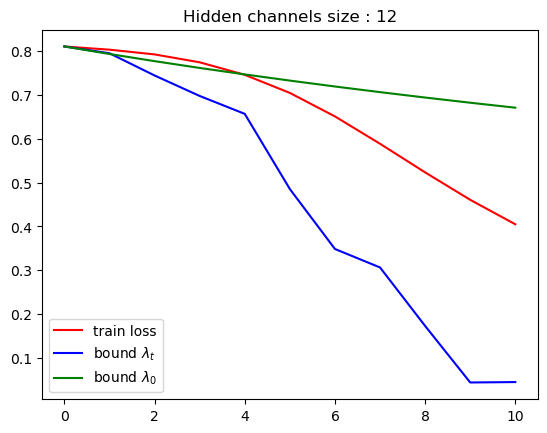

In [9]:
all_losses_10 = []
all_borne_infinie_10 = []
all_borne_finie_10 = []

for i in range(10):
    print(f"**** model {i} ****")

    model = CNN(hidden_channels=12).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    records_loss = []
    records_borne_timesteps = []
    records_borne_lambda0 = []
    records_loss_exp = []

    lambda_min_init, classes = compute_score(model, trainset, device=DEVICE)

    full_score_init = 0
    score_init = []

    for c in classes:
        score_c = torch.sum((1 - F.softmax(model(class_to_data[c]), dim=1)[:,c])**2)
        full_score_init+=score_c
    full_score_init/=len(trainset)
    borne_init = full_score_init

    records_borne_timesteps.append(borne_init.item())
    records_borne_lambda0.append(borne_init.item())
    records_loss_exp.append(borne_init.item())
    
    pbar = trange(10)
    for epoch in pbar:
        model.train()

        running_loss = 0
        for i, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            preds = model(inputs)
            loss = criterion(preds, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        pbar.set_description(f"Epoch : {epoch+1} : loss {running_loss}")

        model.eval()
        lambda_min, classes = compute_score(model, trainset, device=DEVICE)

        full_score = 0
        borne_timesteps = 0
        borne_lambda0 = 0

        for c in classes:
            score_c = sum((1 - F.softmax(model(class_to_data[c]), dim=1)[:,c])**2)
            full_score+=score_c

        borne_timesteps = np.exp(-lambda_min*(epoch+1))*full_score_init.detach()
        borne_lambda0 = np.exp(-lambda_min_init*(epoch+1))*full_score_init.detach()

        full_score = full_score.item()/len(trainset)
        records_borne_timesteps.append(borne_timesteps.item())
        records_borne_lambda0.append(borne_lambda0.item())
        records_loss_exp.append(full_score)
        records_loss.append(running_loss)

    all_losses_10.append(records_loss_exp)
    all_borne_finie_10.append(records_borne_timesteps)
    all_borne_infinie_10.append(records_borne_lambda0)

plt.plot(np.mean(all_losses_10, axis=0), c="red", label="train loss")
plt.plot(np.mean(all_borne_finie_10, axis=0), c="blue", label="bound $\lambda_t$")
plt.plot(np.mean(all_borne_infinie_10, axis=0), c="green", label="bound $\lambda_0$")
plt.title('Hidden channels size : 12')
plt.legend()

# Hidden Channel of size 64

**** model 0 ****


Epoch : 10 : loss 77.7957334369421: 100%|██████████| 10/10 [01:52<00:00, 11.26s/it]


**** model 1 ****


Epoch : 10 : loss 80.90882784128189: 100%|██████████| 10/10 [02:00<00:00, 12.06s/it]


**** model 2 ****


Epoch : 10 : loss 81.31987442076206: 100%|██████████| 10/10 [01:59<00:00, 11.93s/it]


**** model 3 ****


Epoch : 10 : loss 80.34889830648899: 100%|██████████| 10/10 [01:59<00:00, 11.90s/it]


**** model 4 ****


Epoch : 10 : loss 80.25304482877254: 100%|██████████| 10/10 [01:58<00:00, 11.89s/it]


**** model 5 ****


Epoch : 10 : loss 82.85047009587288: 100%|██████████| 10/10 [01:57<00:00, 11.79s/it]


**** model 6 ****


Epoch : 10 : loss 81.9343299716711: 100%|██████████| 10/10 [01:57<00:00, 11.72s/it]


**** model 7 ****


Epoch : 10 : loss 81.9337238073349: 100%|██████████| 10/10 [01:58<00:00, 11.86s/it]


**** model 8 ****


Epoch : 10 : loss 81.85408483445644: 100%|██████████| 10/10 [01:57<00:00, 11.77s/it]


**** model 9 ****


Epoch : 10 : loss 83.3040963113308: 100%|██████████| 10/10 [01:58<00:00, 11.89s/it]


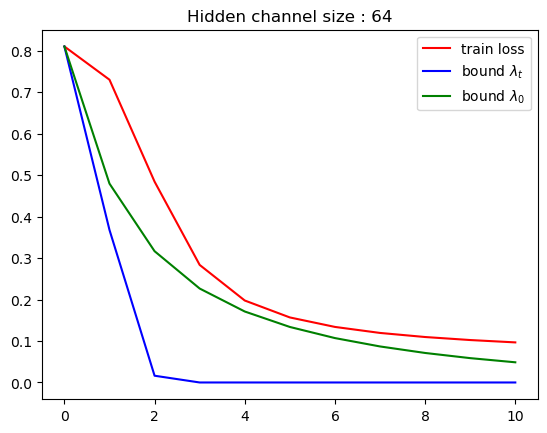

In [10]:
all_losses_100 = []
all_borne_infinie_100 = []
all_borne_finie_100 = []

for i in range(10):
    print(f"**** model {i} ****")

    model = CNN(hidden_channels=64).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    records_loss = []
    records_borne_timesteps = []
    records_borne_lambda0 = []
    records_loss_exp = []

    lambda_min_init, classes = compute_score(model, trainset, device=DEVICE)

    full_score_init = 0
    score_init = []

    for c in classes:
        score_c = torch.sum((1 - F.softmax(model(class_to_data[c]), dim=1)[:,c])**2)
        full_score_init+=score_c
    full_score_init/=len(trainset)
    borne_init = full_score_init

    records_borne_timesteps.append(borne_init.item())
    records_borne_lambda0.append(borne_init.item())
    records_loss_exp.append(borne_init.item())
    
    pbar = trange(10)
    for epoch in pbar:
        model.train()

        running_loss = 0
        for i, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            preds = model(inputs)
            loss = criterion(preds, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        pbar.set_description(f"Epoch : {epoch+1} : loss {running_loss}")

        model.eval()
        lambda_min, classes = compute_score(model, trainset, device=DEVICE)

        full_score = 0
        borne_timesteps = 0
        borne_lambda0 = 0

        for c in classes:
            score_c = sum((1 - F.softmax(model(class_to_data[c]), dim=1)[:,c])**2)
            full_score+=score_c

        borne_timesteps = np.exp(-lambda_min*(epoch+1))*full_score_init.detach()
        borne_lambda0 = np.exp(-lambda_min_init*(epoch+1))*full_score_init.detach()

        full_score = full_score.item()/len(trainset)
        records_borne_timesteps.append(borne_timesteps.item())
        records_borne_lambda0.append(borne_lambda0.item())
        records_loss_exp.append(full_score)
        records_loss.append(running_loss)

    all_losses_100.append(records_loss_exp)
    all_borne_finie_100.append(records_borne_timesteps)
    all_borne_infinie_100.append(records_borne_lambda0)

plt.plot(np.mean(all_losses_100, axis=0), c="red", label="train loss")
plt.plot(np.mean(all_borne_finie_100, axis=0), c="blue", label="bound $\lambda_t$")
plt.plot(np.mean(all_borne_infinie_100, axis=0), c="green", label="bound $\lambda_0$")
plt.title('Hidden channel size : 64')
plt.legend()

# Hidden Chanel of Size 100

**** model 0 ****


Epoch : 10 : loss 68.49793906509876: 100%|██████████| 10/10 [03:04<00:00, 18.41s/it]


**** model 1 ****


Epoch : 10 : loss 67.23465876281261: 100%|██████████| 10/10 [03:09<00:00, 18.95s/it]


**** model 2 ****


Epoch : 10 : loss 69.04057832062244: 100%|██████████| 10/10 [03:08<00:00, 18.90s/it]


**** model 3 ****


Epoch : 10 : loss 69.48114329576492: 100%|██████████| 10/10 [03:09<00:00, 18.95s/it]


**** model 4 ****


Epoch : 10 : loss 67.81543672084808: 100%|██████████| 10/10 [03:08<00:00, 18.85s/it]


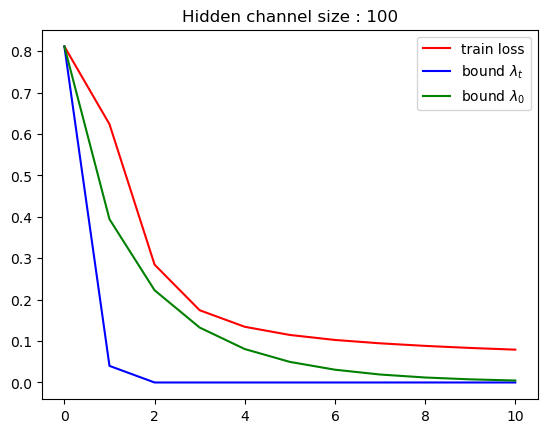

In [17]:
all_losses_1000 = []
all_borne_infinie_1000 = []
all_borne_finie_1000 = []

for i in range(5):
    print(f"**** model {i} ****")

    model = CNN(hidden_channels=100).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    records_loss = []
    records_borne_timesteps = []
    records_borne_lambda0 = []
    records_loss_exp = []

    lambda_min_init, classes = compute_score(model, trainset, device=DEVICE)

    full_score_init = 0
    score_init = []

    for c in classes:
        score_c = torch.sum((1 - F.softmax(model(class_to_data[c]), dim=1)[:,c])**2)
        full_score_init+=score_c
    full_score_init/=len(trainset)
    borne_init = full_score_init

    records_borne_timesteps.append(borne_init.item())
    records_borne_lambda0.append(borne_init.item())
    records_loss_exp.append(borne_init.item())
    
    pbar = trange(10)
    for epoch in pbar:
        model.train()

        running_loss = 0
        for i, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            preds = model(inputs)
            loss = criterion(preds, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        pbar.set_description(f"Epoch : {epoch+1} : loss {running_loss}")

        model.eval()
        lambda_min, classes = compute_score(model, trainset, device=DEVICE)

        full_score = 0
        borne_timesteps = 0
        borne_lambda0 = 0

        for c in classes:
            score_c = sum((1 - F.softmax(model(class_to_data[c]), dim=1)[:,c])**2)
            full_score+=score_c

        borne_timesteps = np.exp(-lambda_min*(epoch+1))*full_score_init.detach()
        borne_lambda0 = np.exp(-lambda_min_init*(epoch+1))*full_score_init.detach()

        full_score = full_score.item()/len(trainset)
        records_borne_timesteps.append(borne_timesteps.item())
        records_borne_lambda0.append(borne_lambda0.item())
        records_loss_exp.append(full_score)
        records_loss.append(running_loss)

    all_losses_1000.append(records_loss_exp)
    all_borne_finie_1000.append(records_borne_timesteps)
    all_borne_infinie_1000.append(records_borne_lambda0)

plt.plot(np.mean(all_losses_1000, axis=0), c="red", label="train loss")
plt.plot(np.mean(all_borne_finie_1000, axis=0), c="blue", label="bound $\lambda_t$")
plt.plot(np.mean(all_borne_infinie_1000, axis=0), c="green", label="bound $\lambda_0$")
plt.title('Hidden channel size : 100')
plt.legend()